In [1]:
import requests
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq
import os.path
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# From https://stackoverflow.com/questions/50786266/writing-dictionary-of-dataframes-to-file
import csv
import pandas as pd

def save_dict_df(dictex, keys_filename="keys.txt", data_folder="hourly_stock_data"):
    for key, val in dictex.items():
        val.to_csv("./"+data_folder+"/data_{}.csv".format(str(key)))

    with open(keys_filename, "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def load_dict_df(keys_filename="keys.txt", data_folder="hourly_stock_data"):
    """Reading data from keys"""
    with open(keys_filename, "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("./"+data_folder+"/data_{}.csv".format(str(key)), index_col=0)

    return dictex

In [3]:
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft', 'apple', 'snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT', 'AAPL', 'SNAP']
stock_columns = ['open', 'high', 'low', 'close', 'volume']

In [4]:
#create kw_list 
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

In [5]:
# Get 3-month ago trend data. May need to run a couple times to make sure it doesn't time out. 
def getTrendDataDF(kw_list, pull_data=False, dates='today 3-m', pytrends_df_filename="hourly_pytrends.csv"):
    # Retrieve the cached trend data
    if not pull_data and os.path.isfile(pytrends_df_filename):
        df = pd.read_csv(pytrends_df_filename, index_col="date")
        
    else: # Construct the dataframe by making pytrends calls
        df = pd.DataFrame()
        data = {}
        #print(df.empty)
        pytrends = TrendReq(hl='en-US', tz=360)
        for kw in kw_list:
            df_temp = pytrends.get_historical_interest([kw], year_start=2019, month_start=11, day_start=25, hour_start=0, year_end=2019, month_end=11, day_end=29, hour_end=23)
            df_temp = df_temp.drop(['isPartial'], axis=1)
            # print(kw)
            data[kw] = df_temp
        for kw in kw_list:
            if df.empty:
                df = data[kw]
            else:
                df = df.join(data[kw])
        df.to_csv(pytrends_df_filename)
    #reverse df rows
    df = df.iloc[::-1]
    return df

In [6]:
# Get Stock Hourly info for past 7 days
def getHourlyStockInfoDict(company_symbol, pull_data=False, stock_df_filename="stock_keys.txt"):
    if not pull_data and os.path.isfile(stock_df_filename):
        dict_stocks = load_dict_df(keys_filename=stock_df_filename);
    else :
        ts = 'TIME_SERIES_INTRADAY'
        api_key = ''
        interval = '30min'
        outputsize = 'full'
        dict_stocks = {}
        for i, symbol in enumerate(company_symbol):
            link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                .format(ts, symbol, interval, api_key, outputsize)
            request = requests.get(link)
            data = json.loads(request.text)
            # API only give you 5 requests per 5 mins, so break out if response is not what is expected.
            while "Time Series (30min)" not in data:
                print('...sleeping...')
                time.sleep(70)
                link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, interval, api_key, outputsize)
                request = requests.get(link)
                data = json.loads(request.text)
            stock_data_per_hour = json.dumps(data["Time Series (30min)"])
            df_temp = pd.read_json(stock_data_per_hour).transpose()
            df_temp.reset_index(level=0, inplace=True)
            df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
            dict_stocks[companies[i]] = df_temp
        save_dict_df(dict_stocks, keys_filename=stock_df_filename)
    return dict_stocks

In [7]:
def getTrends(company_name, df_trends):
    # Filters the trends
    company_keywords =  [x for x in list(df_trends.columns.values) if company_name in x]
    return df_trends[company_keywords].copy()
    

In [8]:
def getJointTimes(df_stock, df_trends): 
    stock_times = df_stock['times']
    trends_times = list(df_trends.index)
    return list(set(stock_times) & set(trends_times)) 

In [9]:
def getOverlapDateData(company_name, dict_stocks, df_trends): 
    new_df_trends = getTrends(company_name, df_trends)
    
    joint_times = getJointTimes(dict_stocks[company_name], new_df_trends)
    new_df_stocks = dict_stocks[company_name].loc[dict_stocks[company_name]['times'].isin(joint_times)]
    new_df_stocks = new_df_stocks.reset_index() 
    
    new_df_trends = new_df_trends.loc[new_df_trends.index.isin(joint_times)]
    new_df_trends = new_df_trends.reset_index()
    new_df_trends.columns = ['_'.join(x.split()) for x in list(new_df_trends.columns) if len(x) > 1]
    df_all_data = new_df_stocks.join(new_df_trends)
    return df_all_data


In [10]:
def trainMultipleRegression(y_col, parameter_cols, training_data): 
    formula = y_col + ' ~ 1'
    for i in parameter_cols: 
        formula = formula + " + " + i

    result = sm.formula.ols(formula=formula, data=training_data).fit()
    return result

In [11]:
def plotMultipleRegressionAndGetMSE(company, result, y_col, cols, all_data, training_data, testing_data):
    y_pred = result.predict()
    plt.plot(range(len(all_data[y_col])) , all_data[y_col])
    plt.plot(range(50), result.predict(training_data[cols]), '-')
    plt.plot(range(50, len(df_all_data[y_col])), result.predict(testing_data[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title(company + ' Multiple Regression: ' + str(y_col))
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    
    MSE = mean_squared_error(result.predict(testing_data[cols]), testing_data[y_col]) / (np.mean(testing_data[y_col]) * np.std(testing_data[y_col]))
    return MSE

In [12]:
def getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train):
    df_all_data_test = df_all_data_train[40:]
    df_all_data_train = df_all_data_train[:40]
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 2000, 10):
        clf = Ridge(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))

    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    
    print("alpha: "+str(bestAlpha))
    print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    print()
    return bestAlpha, clf

In [13]:
#ridge regression

def trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, parameter_cols, df_all_data_train, df_all_data_test) : 
    bestAlpha, clf = getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train)
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    
    #plot data with training and test data
    clf = Ridge(alpha=bestAlpha)
    clf.fit(X, y) 
    plt.plot(range(len(df_all_data[y_col])) , df_all_data[y_col])
    plt.plot(range(50), clf.predict(df_all_data_train[cols]), '-')
    plt.plot(range(50, len(df_all_data[y_col])), clf.predict(df_all_data_test[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title(company + ' Ridge Regression: ' + str(y_col))
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    
    print(clf.get_params())
    MSE = mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]) / (np.mean(df_all_data_test[y_col]) * np.std(df_all_data_test[y_col]))
    return MSE

In [14]:
def getMovingAvgAndStdDev(col_name, num_days, df_all_data):
    # Moving average and stdev past X days
    col_movingAvg = []
    col_stdev = []
    
    num_days_to_average = 10
    for i in range(len(df_all_data)):
        sum_to_avg = 0
        nums = []
        num_to_avg = min(num_days_to_average, len(df_all_data) - i) - 1
        for j in range(1, num_to_avg):
            sum_to_avg += df_all_data[col][i + j]
            nums.append(df_all_data[col][i + j])
        avg = sum_to_avg / (num_to_avg if num_to_avg > 0 else 1)
        stdev = np.std((nums if nums else [0]))

        col_movingAvg.append(avg)
        col_stdev.append(stdev)
    return col_movingAvg, col_stdev

In [15]:
def getAllParamCols(df_all_data):
    cols = list(df_all_data.columns)
    cols.remove('profit')
    cols.remove('open')
    cols.remove('close')
    cols.remove('high')
    cols.remove('low')
    cols.remove('times')
    cols.remove('date')
    cols.remove('index')
    cols.remove('volume')
    cols.remove('mid')
    return cols

In [16]:
# Get trend data
df_trends = getTrendDataDF(kw_list)

In [17]:
# Get stock data
dict_stocks = getHourlyStockInfoDict(company_symbol)

# Lasso Regression with Hourly Data

In [18]:
# Imports
import requests
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn import linear_model
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq
import os.path


**Helper Functions**

In [19]:
def save_dict_df(dictex, keys_filename="keys.txt", data_folder="hourly_stock_data"):
    for key, val in dictex.items():
        val.to_csv("./"+data_folder+"/data_{}.csv".format(str(key)))

    with open(keys_filename, "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def load_dict_df(keys_filename="keys.txt", data_folder="hourly_stock_data"):
    """Reading data from keys"""
    with open(keys_filename, "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("./"+data_folder+"/data_{}.csv".format(str(key)), index_col=0)

    return dictex

In [20]:
def getTrends(company_name, df_trends):
    # Filters the trends
    company_keywords =  [x for x in list(df_trends.columns.values) if company_name in x]
    return df_trends[company_keywords].copy()
    

In [21]:
def getJointTimes(df_stock, df_trends): 
    stock_times = df_stock['times']
    trends_times = list(df_trends.index)
    return list(set(stock_times) & set(trends_times)) 

In [22]:
# Define Company Keyterms and Symbols
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft','apple','snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT','AAPL','SNAP']

In [23]:
#Create Key Word List
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

**Gather Google trends data**

In [24]:
# Get Hourly trends data from pytrends
# If there is a server 500 error, try changing the dates to this past week! 
def getHourlyTrends(company_symbol, pull_data=False, trends_df_filename="hourly_pytrends.csv"):
    if not pull_data and os.path.isfile(trends_df_filename):
        trends_df = pd.read_csv(trends_df_filename, index_col="date")
    else :
        df = pd.DataFrame()
        data = {}
        pytrends = TrendReq(hl='en-US', tz=360)
        for kw in kw_list:
            print(kw)
            df_temp = pytrends.get_historical_interest([kw], year_start=2019, month_start=11, day_start=28, hour_start=0, year_end=2019, month_end=12, day_end=3, hour_end=23, sleep=30)
            if 'isPartial' in df_temp.columns: 
                df_temp = df_temp.drop(['isPartial'], axis=1)
            data[kw] = df_temp
        for kw in kw_list:
            if df.empty:
                df = data[kw]
            else:
                df = df.join(data[kw])
                
        print("finished kw forloop")
        trends_df = df
        df.to_csv(trends_df_filename)
    return trends_df
        

In [25]:
df_trends = getHourlyTrends(company_symbol)

In [26]:
# Inspect Data
df_trends.head()

,tesla report,tesla good,tesla bad,tesla up,tesla down,tesla stock,facebook report,facebook good,facebook bad,facebook up,...,apple bad,apple up,apple down,apple stock,snap report,snap good,snap bad,snap up,snap down,snap stock
date,,,,,,,,,,,,,,,,,,,,,
2019-11-28 00:00:00,95,64,72,91,100,81,85,77,71,68,...,90,71,37,52,61,64,48,67,46,55
2019-11-28 01:00:00,76,67,54,85,77,74,70,82,75,74,...,97,75,33,47,37,45,48,64,35,41
2019-11-28 02:00:00,72,89,66,83,91,71,89,87,74,78,...,89,72,38,40,61,46,39,65,35,34
2019-11-28 03:00:00,100,93,61,58,85,70,78,85,58,81,...,97,79,35,49,96,74,40,70,52,22
2019-11-28 04:00:00,29,76,43,69,68,59,76,84,65,88,...,82,69,34,39,73,47,37,72,54,38


**Gather Stock Data: Alpha Vantage**

In [27]:
# Get Stock Hourly info for past 7 days
def getHourlyStockInfoDict(company_symbol, pull_data=False, stock_df_filename="stock_keys.txt"):
    if not pull_data and os.path.isfile(stock_df_filename):
        dict_stocks = load_dict_df(keys_filename=stock_df_filename);
    else :
        ts = 'TIME_SERIES_INTRADAY'
        api_key = 'E19YNB8R4JKN32DV'
        interval = '30min'
        outputsize = 'full'
        dict_stocks = {}
        for i, symbol in enumerate(company_symbol):
            print(symbol)
            link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                .format(ts, symbol, interval, api_key, outputsize)
            request = requests.get(link)
            data = json.loads(request.text)
            # API only give you 5 requests per 5 mins, so break out if response is not what is expected.
            while "Time Series (30min)" not in data:
                print('...sleeping...')
                time.sleep(70)
                link = 'https://www.alphavantage.co/query?function={}&symbol={}&interval={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, interval, api_key, outputsize)
                request = requests.get(link)
                data = json.loads(request.text)
            stock_data_per_hour = json.dumps(data["Time Series (30min)"])
            df_temp = pd.read_json(stock_data_per_hour).transpose()
            df_temp.reset_index(level=0, inplace=True)
            df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
            dict_stocks[companies[i]] = df_temp
        save_dict_df(dict_stocks, keys_filename=stock_df_filename)
    return dict_stocks

In [28]:
df_stocks = getHourlyStockInfoDict(company_symbol)

In [29]:
# Gather stock data for each individual company
#df_stocks = {}
#for s in company_symbol:
#    print(s)
#    res = getIntraday1minDF(s)
    # data limit reached
#    while res.empty:
#        time.sleep(10)
#        res = getIntraday1minDF(s)
    # add stock information to dictionary
#    df_stocks[s] = res

In [30]:
# Preview Stock Data
df_stocks['tesla'].tail()

,times,open,high,low,close,volume
372,2019-10-24 12:00:00,293.6600,298.2900,292.7000,297.5200,1643473.0
373,2019-10-24 11:30:00,295.2156,295.7645,292.8218,293.7024,1241653.0
374,2019-10-24 11:00:00,292.7300,296.0200,289.2200,295.1500,2866779.0
375,2019-10-24 10:30:00,297.4161,299.7806,292.3937,292.8809,3240948.0
376,2019-10-24 10:00:00,298.3700,304.9500,294.0200,297.4500,11841310.0


In [31]:
#reverse df rows
df_trends = df_trends.iloc[::-1]
df_trends.head()

,tesla report,tesla good,tesla bad,tesla up,tesla down,tesla stock,facebook report,facebook good,facebook bad,facebook up,...,apple bad,apple up,apple down,apple stock,snap report,snap good,snap bad,snap up,snap down,snap stock
date,,,,,,,,,,,,,,,,,,,,,
2019-12-03 23:00:00,71,53,49,32,52,77,88,86,88,68,...,81,78,29,69,30,82,100,83,72,63
2019-12-03 22:00:00,83,69,49,32,70,88,94,79,91,64,...,85,69,27,75,80,68,67,47,51,85
2019-12-03 21:00:00,61,73,45,43,47,95,83,78,90,66,...,69,58,24,87,70,39,73,53,100,90
2019-12-03 20:00:00,60,66,39,41,45,92,80,74,99,62,...,71,56,22,80,59,64,50,49,46,89
2019-12-03 19:00:00,73,58,42,39,48,87,78,67,87,63,...,62,58,21,77,88,40,22,50,50,96


**Merge Trend and Stock Data**

In [32]:
df_trends_stocks = {}
def cleanAndJoinData():
    for s,c in zip(company_symbol, companies):
        print(c)
        company_names = [x for x in list(df_trends.columns.values) if c in x]
        df_temp_trends = df_trends[company_names]
        
        # line up indexes 
        stock_times = list(df_stocks[c].times)
        trends_times = list(df_temp_trends.index)
        joint_times = list(set(stock_times) & set(trends_times)) 
        
        print(joint_times)
        df_temp_stocks = df_stocks[c].loc[df_stocks[c]['times'].isin(joint_times)]
        df_temp_stocks = df_temp_stocks.reset_index()
        df_temp_stocks = df_temp_stocks.iloc[::-1]
        df_temp_trends = df_temp_trends.loc[df_temp_trends.index.isin(joint_times)]
        df_temp_trends = df_temp_trends.reset_index()
        df_temp_trends.columns = ['_'.join(x.split()) for x in list(df_temp_trends.columns) if len(x) > 1]
        df_trends_stocks[c] = df_temp_stocks.join(df_temp_trends,lsuffix='_left', rsuffix='_right')
cleanAndJoinData()

tesla
['2019-11-29 11:00:00', '2019-12-02 11:00:00', '2019-12-03 16:00:00', '2019-12-03 12:00:00', '2019-12-02 15:00:00', '2019-12-02 14:00:00', '2019-12-02 12:00:00', '2019-11-29 12:00:00', '2019-12-02 16:00:00', '2019-12-03 15:00:00', '2019-11-29 10:00:00', '2019-12-03 14:00:00', '2019-11-29 13:00:00', '2019-12-03 13:00:00', '2019-12-02 13:00:00', '2019-12-03 11:00:00', '2019-12-03 10:00:00', '2019-12-02 10:00:00']
facebook
['2019-11-29 11:00:00', '2019-12-02 11:00:00', '2019-12-03 16:00:00', '2019-12-03 12:00:00', '2019-12-02 15:00:00', '2019-12-02 14:00:00', '2019-12-02 12:00:00', '2019-11-29 12:00:00', '2019-12-02 16:00:00', '2019-12-03 15:00:00', '2019-11-29 10:00:00', '2019-12-03 14:00:00', '2019-11-29 13:00:00', '2019-12-03 13:00:00', '2019-12-02 13:00:00', '2019-12-03 11:00:00', '2019-12-03 10:00:00', '2019-12-02 10:00:00']
microsoft
['2019-11-29 11:00:00', '2019-12-02 11:00:00', '2019-12-03 16:00:00', '2019-12-03 12:00:00', '2019-12-02 15:00:00', '2019-12-02 14:00:00', '2019-

**Function for calculating new predictors**

In [33]:
def getMovingAvgAndStdDev(col_name, num_days, df_all_data):
    # Moving average and stdev past X days
    col_movingAvg = []
    col_stdev = []
    
    num_days_to_average = 10
    for i in range(len(df_all_data)):
        sum_to_avg = 0
        nums = []
        num_to_avg = min(num_days_to_average, len(df_all_data) - i) - 1
        for j in range(1, num_to_avg):
            sum_to_avg += df_all_data[col][i + j]
            nums.append(df_all_data[col][i + j])
        avg = sum_to_avg / (num_to_avg if num_to_avg > 0 else 1)
        stdev = np.std((nums if nums else [0]))

        col_movingAvg.append(avg)
        col_stdev.append(stdev)
    return col_movingAvg, col_stdev

**Add Additional Predictors to model**

In [34]:
def getAllParamCols(df_all_data):
    cols = list(df_all_data.columns)
    cols.remove('open')
    cols.remove('close')
    cols.remove('high')
    cols.remove('low')
    cols.remove('times')
    cols.remove('date')
    cols.remove('index')
    cols.remove('volume')
    cols.remove('profit')
    cols.remove('mid')
    cols.remove('volume_movingAvg')
    cols.remove('volume_stdev')
    cols.remove('profit_movingAvg')
    cols.remove('profit_stdev')
    cols.remove('mid_movingAvg')
    cols.remove('mid_stdev')
    return cols

In [35]:
# Add predictors
for company in df_trends_stocks: 
    # Calculate Profit For Each Company in Dict
    (df_trends_stocks[company])['profit'] = (df_trends_stocks[company])['open']-(df_trends_stocks[company])['close']
    (df_trends_stocks[company])['mid'] = ((df_trends_stocks[company])['high']+(df_trends_stocks[company])['low'])/2
    # Calculate Moving Averages and Standard Deviation for Stock Data
    # For Profit
    num_days_to_average = 10
    col = 'profit'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
    (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
    (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_trends_stocks[company][col+'_prev'] = col_prev
    # For Mid
    col = 'mid'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
    (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
    (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_trends_stocks[company][col+'_prev'] = col_prev
    # For Volume
    col = 'volume'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
    (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
    (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    cols = getAllParamCols(df_trends_stocks[company])
    col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_trends_stocks[company][col+'_prev'] = col_prev
    
    # Calculate Increment Over time
    for col in cols: 
        # Prev 
        col_prev = [(df_trends_stocks[company])[col][i+1] for i in range(len((df_trends_stocks[company])) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        #df_all_data[col+'_prev'] = col_prev
        (df_trends_stocks[company])[col+'_prev'] = col_prev
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_trends_stocks[company])
        
        (df_trends_stocks[company])[col+'_movingAvg'] = col_movingAvg
        (df_trends_stocks[company])[col+'_stdev'] = col_stdev
    # Reverse index order
    df_trends_stocks[company] = df_trends_stocks[company].iloc[::-1] 

**LASSO Regression Helper Functions**

In [36]:
# Methods for LASSO Regression
def getBestAlphaLASSORegression(y_col, parameter_cols, df_all_data_train):
    split = int(df_all_data_train.shape[0]/2)
    df_all_data_test = df_all_data_train[split:]
    df_all_data_train = df_all_data_train[:split]
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 10000, 10):
        clf = linear_model.Lasso(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))
    
    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    clf = linear_model.Lasso(alpha=bestAlpha)
    clf.fit(X, y)
    bestMSE = mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])
    print("alpha: "+str(bestAlpha))
    print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    print()
    return bestAlpha, bestMSE

In [37]:
# Define Functions For Plotting LASSO Regression
def plotLASSO(company, alpha, label, predictors, df): 
    # Separate Data
    split = int(df.shape[0]/2)
    df_train = df[:split]
    df_test = df[split:]
    X_train = df_train[predictors]
    Y_train = df_train[label]
    X_test = df_test[predictors]
    Y_test = df_test[label]
    Y_labels = df[label]
    # Initialize Model w/ Optimal Alpha
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X_train, Y_train) 
    param_dict = dict(zip(clf.coef_, predictors))
    print("Parameter Estimates w/ LASSO : ",param_dict)
    # Make Predictions using optimal alpha value
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    # Plot test and train predictions against true labels
    
    fig1, ax1 = plt.subplots()
    ax1.plot(range(split), y_pred_train, color='r')
    ax1.plot(range(split, len(Y_labels)),y_pred_test, color='b')
    ax1.plot(range(len(Y_labels)),Y_labels, color='g')
    ax1.set_xlabel('Time in Hours')
    ax1.set_ylabel(label)
    ax1.set_title(label + ' Predictions with LASSO Regression for '+ company)

**Run regression and view dropped features for each company**

In [38]:
def columnsAll(company, label): 
    cols = df_trends_stocks[company].columns
    cols = list(cols)
    cols.remove('times')
    cols.remove('index')
    cols.remove('date')
    cols.remove(label)
    return cols

def columnsTrends(company, label): 
    cols = [x for x in list(df_trends_stocks[company].columns) if company in x]
    return cols

def columnsAverage(company, label): 
    cols = [x for x in list(df_trends_stocks[company].columns) if company not in x]
    cols.remove(label)
    cols.remove('times')
    cols.remove('index')
    cols.remove('date')
    cols.remove('open')
    cols.remove('volume')
    cols.remove('high')
    cols.remove('low')
    cols.remove('close')
    cols.remove('profit')
    return cols

# Plot Predictions w/ All Predictors

In [39]:
keys = ['All Predictors', 'Just Trends','Just Stock Data']
MSE = {key: None for key in keys}
MSE_companies = {company: MSE.copy() for company in companies}

In [40]:
print(MSE_companies)

{'tesla': {'All Predictors': None, 'Just Trends': None, 'Just Stock Data': None}, 'facebook': {'All Predictors': None, 'Just Trends': None, 'Just Stock Data': None}, 'microsoft': {'All Predictors': None, 'Just Trends': None, 'Just Stock Data': None}, 'amazon': {'All Predictors': None, 'Just Trends': None, 'Just Stock Data': None}, 'google': {'All Predictors': None, 'Just Trends': None, 'Just Stock Data': None}, 'uber': {'All Predictors': None, 'Just Trends': None, 'Just Stock Data': None}, 'lyft': {'All Predictors': None, 'Just Trends': None, 'Just Stock Data': None}, 'apple': {'All Predictors': None, 'Just Trends': None, 'Just Stock Data': None}, 'snap': {'All Predictors': None, 'Just Trends': None, 'Just Stock Data': None}}


alpha: 90
Training error = 0.09780333719915575
Testing error = 11.303421161048867

Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -8.828304740028648e-08: 'volume', -1.8338806691502878e-06: 'volume_movingAvg', -3.0465894406302984e-06: 'volume_stdev', 6.597111900271047e-07: 'volume_prev'}
alpha: 90
Training error = 0.6305440124300655
Testing error = 1.480622904153429

Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -1.201962113337837e-06: 'volume', -3.624705300008292e-06: 'volume_movingAvg', 8.444896395136747e-06: 'volume_stdev', -2.06584595711039e-06: 'volume_prev'}
alpha: 90
Training error = 0.14841444102316917
Testing error = 0.7942206702672983

Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -2.7042870970486556e-07: 'volume', -1.034298251342438e-06: 'volume_movingAvg', 2.7391636278811377e-06: 'volume_stdev', -8.595028239220359e-07: 'volume_prev'}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.225189575319376, tolerance: 0.10310157816738781
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.98385709894377, tolerance: 0.10310157816738781
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.237211978914274, tolerance: 0.10310157816738781
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear

alpha: 310
Training error = 15.16223808474697
Testing error = 336.0794694522222

Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -4.67892485584535e-06: 'volume', -0.00029147535900900397: 'volume_movingAvg', 0.00042142317146956953: 'volume_stdev', -7.445397725813494e-05: 'volume_prev', 0.01182028536336494: 'mid_prev_prev'}
alpha: 90
Training error = 4.45564336147979
Testing error = 149.39027180214464

Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -2.3185916273814054e-05: 'volume', -0.0002897700181891776: 'volume_movingAvg', 0.00026737709095992423: 'volume_stdev', -5.1675407264485695e-05: 'volume_prev', 0.0005663032608963604: 'mid_prev_prev'}
alpha: 90
Training error = 0.0061537133659333105
Testing error = 0.08838812292789547

Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -1.0534541511306981e-07: 'volume', -3.7125645747274345e-07: 'volume_movingAvg', 5.931838334165994e-07: 'volume_stdev', -6.69489367404677e-08: 'volume_prev'}
alpha: 90
Training error = 0.01146

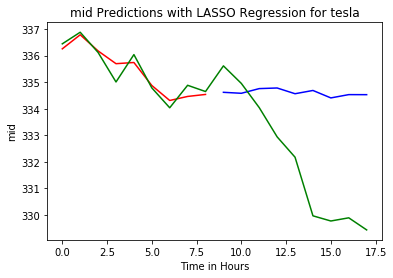

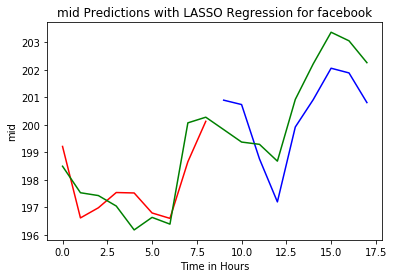

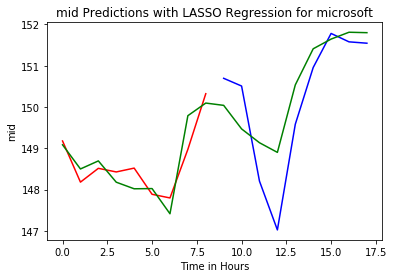

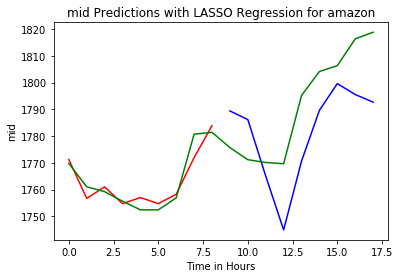

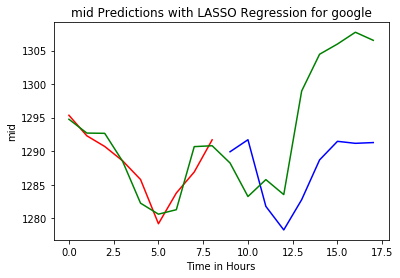

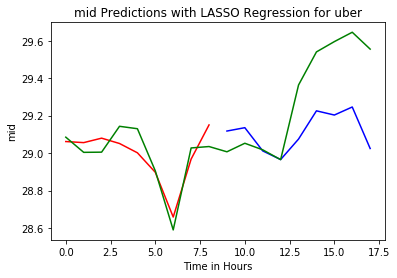

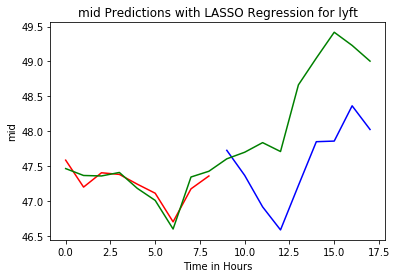

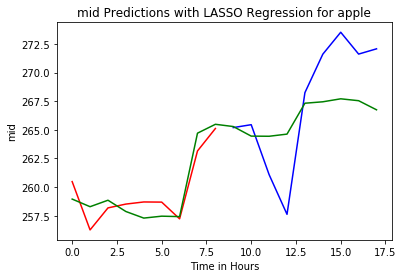

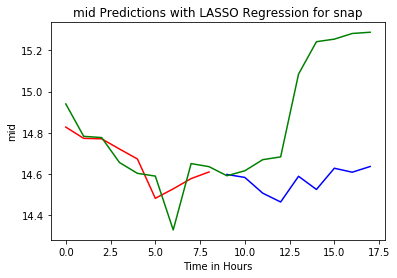

In [41]:
for company in companies: 
    # Prepare column list
    cols = columnsAll(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha, MSE_all = getBestAlphaLASSORegression('mid',cols,df_trends_stocks[company])
    # Plot Predictions by True Labels
    plotLASSO(company, alpha, 'mid', cols, df_trends_stocks[company])
    # Plot MSE for LASSO Regression
    MSE_companies[company]['All Predictors']  = MSE_all

# Plot Predictions for Just Trends Data

alpha: 90
Training error = 0.822864444444456
Testing error = 16.320080259259534

Parameter Estimates w/ LASSO :  {0.0: 'tesla_stock_stdev'}
alpha: 90
Training error = 2.053331691358027
Testing error = 13.102869354938047

Parameter Estimates w/ LASSO :  {0.0: 'facebook_stock_stdev'}
alpha: 90
Training error = 0.6818572777777866
Testing error = 4.791586944444545

Parameter Estimates w/ LASSO :  {0.0: 'microsoft_stock_stdev'}
alpha: 280
Training error = 114.55730907487538
Testing error = 1193.7570621419902

Parameter Estimates w/ LASSO :  {0.0: 'amazon_stock_stdev'}
alpha: 100
Training error = 26.328779697776962
Testing error = 161.97055524805538

Parameter Estimates w/ LASSO :  {0.0: 'google_stock_stdev'}
alpha: 90
Training error = 0.024790619506172833
Testing error = 0.17251312595678955

Parameter Estimates w/ LASSO :  {0.0: 'uber_stock_stdev'}
alpha: 90
Training error = 0.06914054450617174
Testing error = 2.0032458495370418

Parameter Estimates w/ LASSO :  {0.0: 'lyft_stock_stdev'}
alp

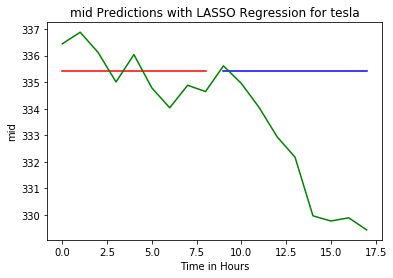

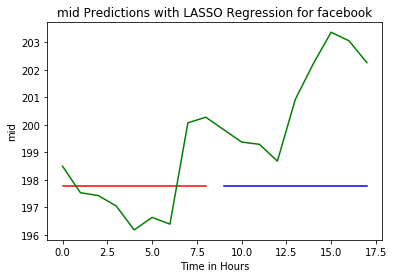

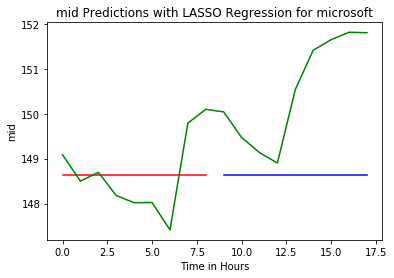

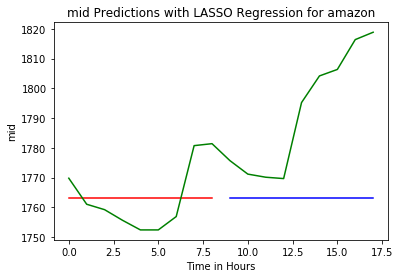

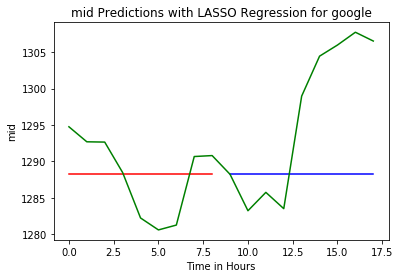

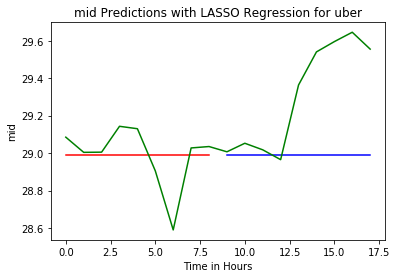

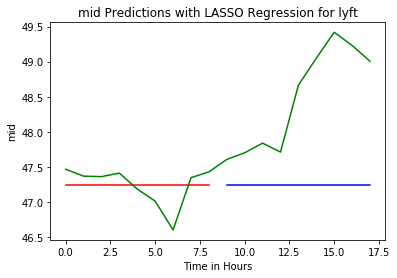

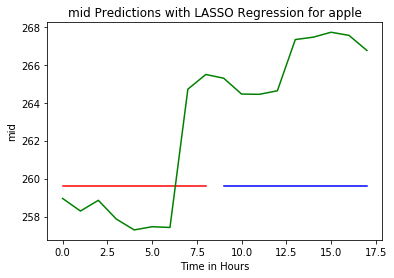

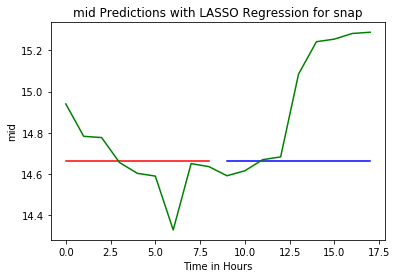

In [42]:
for company in companies: 
    # Prepare column list
    cols = columnsTrends(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha, MSE_trends = getBestAlphaLASSORegression('mid',cols,df_trends_stocks[company])
    # Plot Predictions by True Labels
    plotLASSO(company, alpha, 'mid', cols, df_trends_stocks[company])
    # Plot MSE train and test for LASSO Regression
    MSE_companies[company]['Just Trends']  = MSE_trends

# Plot Predictions for Just Stock Data

alpha: 90
Training error = 0.09868148250711727
Testing error = 11.266642720431364

MSE:  11.266642720431364
Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -1.7901991336678183e-06: 'volume_movingAvg', -3.134343762756381e-06: 'volume_stdev', 6.67197360698355e-07: 'volume_prev'}
alpha: 90
Training error = 1.1272083625740519
Testing error = 2.609237323688492

MSE:  2.609237323688492
Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -3.2545766028931393e-06: 'volume_movingAvg', 6.360091584981814e-06: 'volume_stdev', -1.5414172430846634e-06: 'volume_prev'}
alpha: 90
Training error = 0.27643750023034885
Testing error = 0.9707839801338584

MSE:  0.9707839801338584
Parameter Estimates w/ LASSO :  {-0.0: 'mid_prev_stdev', -1.0395977925267776e-06: 'volume_movingAvg', 2.3079928908280243e-06: 'volume_stdev', -7.896751950026573e-07: 'volume_prev'}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2283502602743113, tolerance: 0.10310157816738781
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.23134479923813, tolerance: 0.10310157816738781
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171753111029915, tolerance: 0.10310157816738781
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_

alpha: 230
Training error = 13.974697527657867
Testing error = 312.7493007879254

MSE:  312.7493007879254
Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -0.0003235157376681353: 'volume_movingAvg', 0.0004529536160930694: 'volume_stdev', -7.956415812155383e-05: 'volume_prev', 0.014322524879815309: 'mid_prev_prev'}
alpha: 90
Training error = 5.259313923597953
Testing error = 149.0411074452333

MSE:  149.0411074452333
Parameter Estimates w/ LASSO :  {-0.0: 'mid_prev_stdev', -0.0002985928665569962: 'volume_movingAvg', 0.0002456017460065839: 'volume_stdev', -4.4813229095720706e-05: 'volume_prev', 0.0029124727832061355: 'mid_prev_prev'}
alpha: 90
Training error = 0.015385028225061085
Testing error = 0.15312312214003965

MSE:  0.15312312214003965
Parameter Estimates w/ LASSO :  {0.0: 'mid_prev_stdev', -3.6114772300868873e-07: 'volume_movingAvg', 4.933418391983034e-07: 'volume_stdev', -1.021533786194432e-07: 'volume_prev'}
alpha: 9990
Training error = 0.04916913249441734
Testing error 

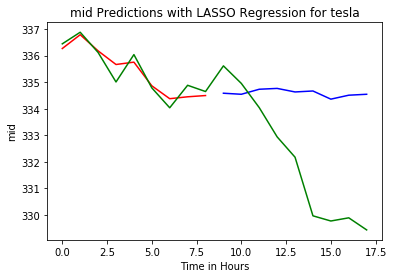

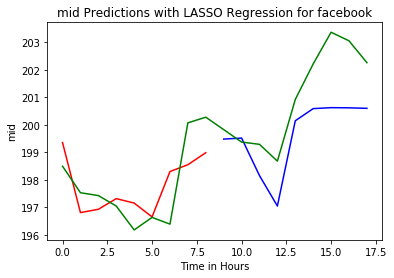

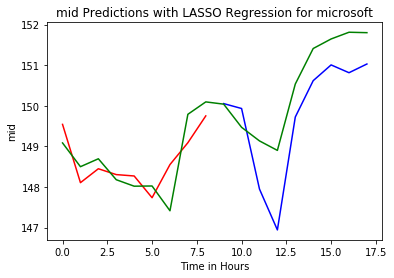

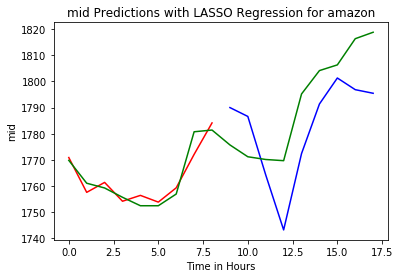

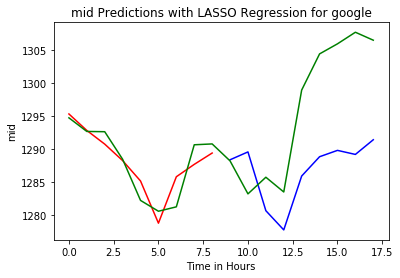

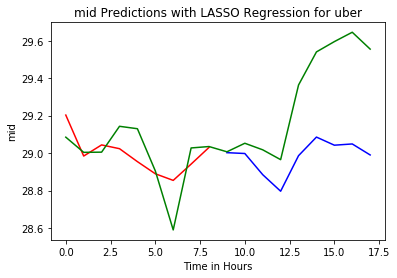

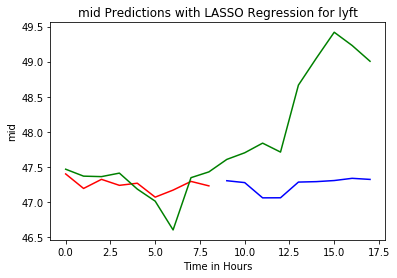

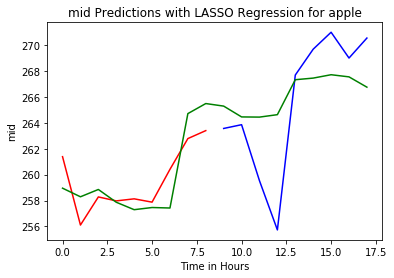

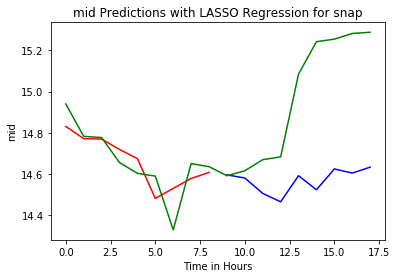

In [43]:
for company in companies: 
    # Prepare column list
    cols = columnsAverage(company, 'mid') 
    # Find best alpha for LASSO Regression
    alpha, MSE_stock = getBestAlphaLASSORegression('mid',cols,df_trends_stocks[company])
    print("MSE: ",MSE_stock)
    # Plot Predictions by True Labels
    plotLASSO(company, alpha, 'mid', cols, df_trends_stocks[company])
    # Plot MSE train and test for LASSO Regression
    MSE_companies[company]['Just Stock Data']  = MSE_stock

In [44]:
print(MSE_companies)

{'tesla': {'All Predictors': 11.303421161048867, 'Just Trends': 16.320080259259534, 'Just Stock Data': 11.266642720431364}, 'facebook': {'All Predictors': 1.480622904153429, 'Just Trends': 13.102869354938047, 'Just Stock Data': 2.609237323688492}, 'microsoft': {'All Predictors': 0.7942206702672983, 'Just Trends': 4.791586944444545, 'Just Stock Data': 0.9707839801338584}, 'amazon': {'All Predictors': 336.0794694522222, 'Just Trends': 1193.7570621419902, 'Just Stock Data': 312.7493007879254}, 'google': {'All Predictors': 149.39027180214464, 'Just Trends': 161.97055524805538, 'Just Stock Data': 149.0411074452333}, 'uber': {'All Predictors': 0.08838812292789547, 'Just Trends': 0.17251312595678955, 'Just Stock Data': 0.15312312214003965}, 'lyft': {'All Predictors': 1.0981833100929748, 'Just Trends': 2.0032458495370418, 'Just Stock Data': 1.9128728708985787}, 'apple': {'All Predictors': 17.569186327671666, 'Just Trends': 45.181788605833866, 'Just Stock Data': 15.434133455779651}, 'snap': {'A

In [45]:
def values(dictionary): 
    vals = []
    for val in dictionary: 
        vals.append(dictionary[val])
    return vals

[11.303421161048867, 16.320080259259534, 11.266642720431364]
[1.480622904153429, 13.102869354938047, 2.609237323688492]
[0.7942206702672983, 4.791586944444545, 0.9707839801338584]
[336.0794694522222, 1193.7570621419902, 312.7493007879254]
[149.39027180214464, 161.97055524805538, 149.0411074452333]
[0.08838812292789547, 0.17251312595678955, 0.15312312214003965]
[1.0981833100929748, 2.0032458495370418, 1.9128728708985787]
[17.569186327671666, 45.181788605833866, 15.434133455779651]
[0.234805558067216, 0.18363582768518505, 0.23633157231904167]


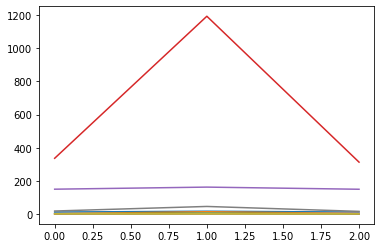

In [46]:
fig1, ax = plt.subplots()
for company in companies: 
    ax.plot(values(MSE_companies[company]))
    ax.set_ylabel('MSE Test')
    #ax.set_xlabel('')
    ax.set_title('MSE Test v. Subset of Predictors')